Disclaimer: Code stolen liberally from various tutorials and guides and (MIT licensed) github repos

In [ ]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split

from datasets import load_dataset

import time
import math

from tqdm import tqdm
from random import randint
from transformers import DataCollatorForLanguageModeling
from transformers import PreTrainedTokenizerFast

In [ ]:
tokenizer = PreTrainedTokenizerFast(tokenizer_file="C:\\Users\\PUGGERNAUT\\Desktop\\c4-bpe\\tokenizer.json")
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

print("Is she fast", tokenizer.is_fast)


Is she fast True


In [ ]:
#Define Toy Transformer model
class TransformerDecoderModel(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_decoder_layers, activation, dim_feedforward, max_seq_length):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model).cuda()
        self.pos_encoder = nn.Parameter(torch.randn(1, max_seq_length, d_model)).cuda()
        self.decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward
        ).cuda()
        self.transformer_decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=num_decoder_layers).cuda()
        self.output_layer = nn.Linear(d_model, vocab_size).cuda()  # Final output layer
        self.vocab_size = vocab_size
        self.d_model = d_model

    def generate_square_subsequent_mask(self, sz):
        # Generates a square mask for the sequence to mask out subsequent positions
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask


    def forward(self, src, tgt,  tgt_mask=None, tgt_key_padding_mask=None):
        assert src.max() < self.vocab_size, "src contains invalid token indices"
        assert tgt.max() < self.vocab_size, "tgt contains invalid token indices"
        assert src.min() >= 0, "src contains negative indices"
        assert tgt.min() >= 0, "tgt contains negative indices"
        #print("Max input token index:", src.max().item(), "Max output token index:", src.max().item(), "Max input sequence length:", src.size(1), "Max output sequence length:", src.size(1))
        src = self.embedding(src) * math.sqrt(self.d_model)
        tgt = self.embedding(tgt) * math.sqrt(self.d_model)
        # Adding positional encoding
        src = src + self.pos_encoder[:, :src.size(1)]
        tgt = tgt + self.pos_encoder[:, :tgt.size(1)]
        #output = self.transformer(src=src, tgt=tgt)

         # Create masks if not provided
        if tgt_mask is None:
            tgt_mask = self.generate_square_subsequent_mask(tgt.size(0)).to(tgt.device)

        # Since there is no encoder, the memory is just a dummy tensor with proper dimensions
        memory = torch.zeros((1, tgt.size(1), self.d_model), device=tgt.device)

        # Pass through the transformer decoder
        output = self.transformer_decoder(tgt=src, memory=memory, tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_key_padding_mask)
        output = self.output_layer(output)
        return output
modelA = TransformerDecoderModel(d_model=256, nhead=1, num_decoder_layers=1, dim_feedforward=512, activation=torch.nn.ReLU, vocab_size=100608, max_seq_length=2048)
modelB = TransformerDecoderModel(d_model=256, nhead=1, num_decoder_layers=1, dim_feedforward=512, activation=torch.nn.ReLU, vocab_size=100608, max_seq_length=2048)
modelMerged = TransformerDecoderModel(d_model=256, nhead=1, num_decoder_layers=1, dim_feedforward=512, activation=torch.nn.ReLU, vocab_size=100608, max_seq_length=2048)

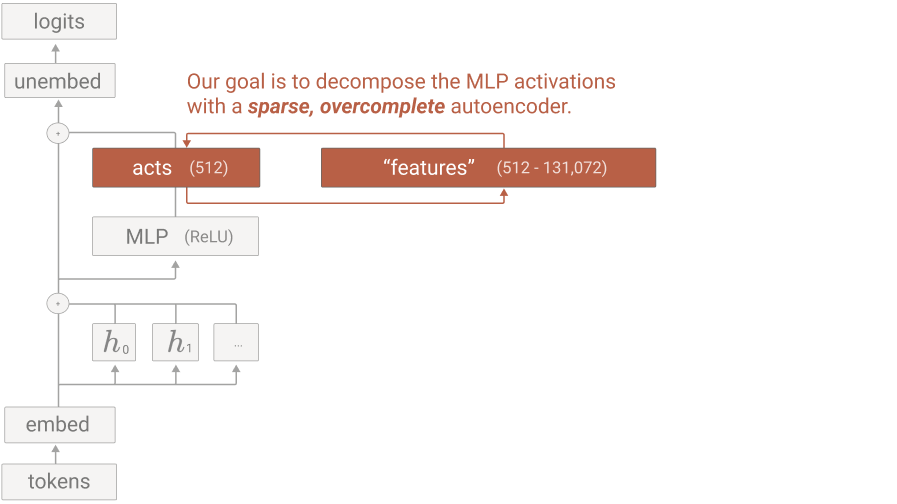

In [ ]:
total_params = sum(p.numel() for p in modelMerged.parameters() if p.requires_grad)
print("Total parameters:", total_params)

Total parameters: 53193472


In [ ]:
#Define optimizers
optimizerA = torch.optim.SGD(modelA.parameters(), lr=0.001, momentum=0.9) #git rebasin doesn't replicate with Adam
optimizerB = torch.optim.SGD(modelB.parameters(), lr=0.001, momentum=0.9)

In [ ]:
#set up dataloader just so we can check the loss
dc = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
def remove_negative_indices(tensor):
    """Replace negative indices in a tensor with a valid index, such as the padding index."""
    padding_index = 0  # Assuming 0 is your padding index; adjust as needed
    tensor[tensor < 0] = padding_index
    return tensor
validation_file = "E:\\c4\\en\\c4-train." + str("0" * 4) + str(randint(0,8)) + "-of-01024.json.gz"
v_dataset = load_dataset('json', data_files=validation_file)
v_dataset = v_dataset.remove_columns(["url", "timestamp"])
start_time = time.time()
v_dataset['train'] = v_dataset['train'].map(lambda e: tokenizer(e['text']), batched=True)
end_time = time.time()
print("Tokenization of validation data took", end_time-start_time, "seconds")
v_dataset['train'] = v_dataset['train'].remove_columns(["text", "token_type_ids", "attention_mask"])
val_dl = DataLoader(v_dataset['train'], shuffle=True, batch_size=12, collate_fn=dc)

Tokenization of validation data took 0.40345072746276855 seconds


In [ ]:
checkpointA = torch.load("modelA_latest.pt")
modelA.load_state_dict(checkpointA['model_state_dict'])
optimizerA.load_state_dict(checkpointA['optimizer_state_dict'])

checkpointB = torch.load("modelB_latest.pt")
modelB.load_state_dict(checkpointB['model_state_dict'])
optimizerB.load_state_dict(checkpointB['optimizer_state_dict'])

In [ ]:
#linear interpolation utils
import copy

def flatten_params(model):
  return model.state_dict()

def lerp(lam, t1, t2):
  t3 = copy.deepcopy(t2)
  for p in t1:
    t3[p] = (1 - lam) * t1[p] + lam * t2[p]
  return t3

In [ ]:
def test(model):
    val_examples = 100
    max_seq_length = 512
    loss = 0
    with torch.no_grad():
        for index, batch in enumerate(val_dl):
            if index > val_examples:
                break
            batch["labels"] = remove_negative_indices(batch["labels"]).cuda()

            outputs = model(src=batch["input_ids"][:, :max_seq_length].cuda(), tgt=batch["labels"][:, :max_seq_length].cuda())
            loss_fn = nn.CrossEntropyLoss(ignore_index=50304)

            # Flatten the output and target tensors
            outputs_flattened = outputs.view(-1, outputs.shape[-1])  # Shape: [sequence_length * batch_size, vocab_size]
            targets_flattened = batch["labels"][:, :max_seq_length].reshape(-1)  # Shape: [sequence_length * batch_size]
            loss += loss_fn(outputs_flattened, targets_flattened)
    return loss/val_examples

In [ ]:
#naive linear interpolation
#we expect this to fail
lambdas = torch.linspace(0, 1, steps=25)
model_a_dict = copy.deepcopy(modelA.state_dict())
model_b_dict = copy.deepcopy(modelB.state_dict())
test_loss_interp_naive = []
for lam in tqdm(lambdas):
    naive_p = lerp(lam, model_a_dict, model_b_dict)
    modelMerged.load_state_dict(naive_p)
    test_loss = test(modelMerged.cuda()).cpu()
    test_loss_interp_naive.append(test_loss)

  0%|                                                                                           | 0/25 [00:00<?, ?it/s]C:\Users\PUGGERNAUT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:20<00:00,  3.23s/it]


In [ ]:
print(test_loss_interp_naive)
test_loss_interp_naive = [l.cpu() for l in test_loss_interp_naive]

[tensor(0.0012), tensor(0.0012), tensor(0.0025), tensor(0.0047), tensor(0.0098), tensor(0.0200), tensor(0.0384), tensor(0.0642), tensor(0.0969), tensor(0.1324), tensor(0.1705), tensor(0.1979), tensor(0.2069), tensor(0.2081), tensor(0.1928), tensor(0.1656), tensor(0.1280), tensor(0.0969), tensor(0.0654), tensor(0.0427), tensor(0.0261), tensor(0.0168), tensor(0.0116), tensor(0.0095), tensor(0.0068)]


C:\Users\PUGGERNAUT\AppData\Local\Temp\ipykernel_24152\3969430163.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


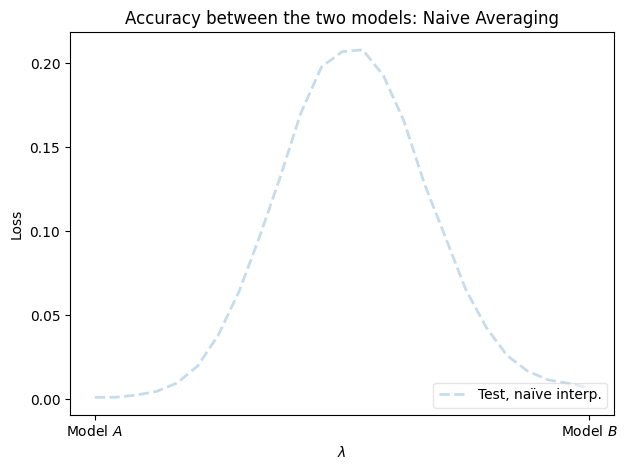

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(lambdas,
          test_loss_interp_naive,
          linestyle="dashed",
          color="tab:blue",
          alpha=0.25,
          linewidth=2,
          label="Test, naïve interp.")
ax.set_xlabel("$\lambda$")
ax.set_xticks([0, 1])
ax.set_xticklabels(["Model $A$", "Model $B$"])
ax.set_ylabel("Loss")
ax.set_title(f"Accuracy between the two models: Naive Averaging")
ax.legend(loc="lower right", framealpha=0.5)
fig.tight_layout()
fig.show()

In [ ]:
from collections import defaultdict
from re import L
from typing import NamedTuple

import torch
from scipy.optimize import linear_sum_assignment



class PermutationSpec(NamedTuple):
  perm_to_axes: dict
  axes_to_perm: dict

def permutation_spec_from_axes_to_perm(axes_to_perm: dict) -> PermutationSpec:
  perm_to_axes = defaultdict(list)
  for wk, axis_perms in axes_to_perm.items():
    for axis, perm in enumerate(axis_perms):
      if perm is not None:
        perm_to_axes[perm].append((wk, axis))
  return PermutationSpec(perm_to_axes=dict(perm_to_axes), axes_to_perm=axes_to_perm)
print(flatten_params(modelA.cpu()).keys())
perm_dict = {}
for index, key in enumerate(flatten_params(modelA.cpu()).keys()):
  perm_dict[key] = (f"p{index}", )
perm_dict = {"embedding.weight": ("p0", None), "decoder_layer.linear1.weight": ("p1", None), "decoder_layer.linear2.weight": ("p2",None), "output_layer.weight": ("p3", None)}
permutation_spec = permutation_spec_from_axes_to_perm(perm_dict)
#May need to add embeddings and output_layer

odict_keys(['embedding.weight', 'decoder_layer.self_attn.in_proj_weight', 'decoder_layer.self_attn.in_proj_bias', 'decoder_layer.self_attn.out_proj.weight', 'decoder_layer.self_attn.out_proj.bias', 'decoder_layer.multihead_attn.in_proj_weight', 'decoder_layer.multihead_attn.in_proj_bias', 'decoder_layer.multihead_attn.out_proj.weight', 'decoder_layer.multihead_attn.out_proj.bias', 'decoder_layer.linear1.weight', 'decoder_layer.linear1.bias', 'decoder_layer.linear2.weight', 'decoder_layer.linear2.bias', 'decoder_layer.norm1.weight', 'decoder_layer.norm1.bias', 'decoder_layer.norm2.weight', 'decoder_layer.norm2.bias', 'decoder_layer.norm3.weight', 'decoder_layer.norm3.bias', 'transformer_decoder.layers.0.self_attn.in_proj_weight', 'transformer_decoder.layers.0.self_attn.in_proj_bias', 'transformer_decoder.layers.0.self_attn.out_proj.weight', 'transformer_decoder.layers.0.self_attn.out_proj.bias', 'transformer_decoder.layers.0.multihead_attn.in_proj_weight', 'transformer_decoder.layers.0.

In [ ]:
import gc  # Import garbage collector interface
from scipy.optimize import linear_sum_assignment
def get_permuted_param(ps: PermutationSpec, perm, k: str, params, except_axis=None):
  """Get parameter `k` from `params`, with the permutations applied."""
  w = params[k]
  for axis, p in enumerate(ps.axes_to_perm[k]):
    # Skip the axis we're trying to permute.
    if axis == except_axis:
      continue

    # None indicates that there is no permutation relevant to that axis.
    if p is not None:
        w = torch.index_select(w, axis, perm[p].int())

  return w

def apply_permutation(ps: PermutationSpec, perm, params):
  """Apply a `perm` to `params`."""
  return {k: get_permuted_param(ps, perm, k, params) for k in params.keys()}

def weight_matching(ps: PermutationSpec, params_a, params_b, max_iter=100, init_perm=None):
  """Find a permutation of `params_b` to make them match `params_a`."""
  perm_sizes = {p: params_a[axes[0][0]].shape[axes[0][1]] for p, axes in ps.perm_to_axes.items()}

  perm = {p: torch.arange(n) for p, n in perm_sizes.items()} if init_perm is None else init_perm
  perm_names = list(perm.keys())

  for iteration in tqdm(range(max_iter)):
    progress = False
    for p_ix in torch.randperm(len(perm_names)):
      p = perm_names[p_ix]
      print(p)
      n = perm_sizes[p]
      A = torch.zeros((n, n))
      for wk, axis in ps.perm_to_axes[p]:
        w_a = params_a[wk]
        w_b = get_permuted_param(ps, perm, wk, params_b, except_axis=axis)
        w_a = torch.moveaxis(w_a, axis, 0).reshape((n, -1))
        w_b = torch.moveaxis(w_b, axis, 0).reshape((n, -1))
        A += w_a @ w_b.T
        # Clear memory of tensors that are no longer needed
        del w_a, w_b
        gc.collect()  # Force garbage collection
      ri, ci = linear_sum_assignment(A.detach().numpy(), maximize=True)
      assert (torch.tensor(ri) == torch.arange(len(ri))).all()
      oldL = torch.einsum('ij,ij->i', A, torch.eye(n)[perm[p].long()]).sum()
      newL = torch.einsum('ij,ij->i', A,torch.eye(n)[ci, :]).sum()
      print(f"{iteration}/{p}: {newL - oldL}")
      progress = progress or newL > oldL + 1e-12

      perm[p] = torch.Tensor(ci)
      del A
      gc.collect()  # Force garbage collection
    if not progress:
      break

  return perm

This was using way too much memory which I tried to resolve with manual garbage collection. It also would hold onto the memory after the jupyter shell was closed.  

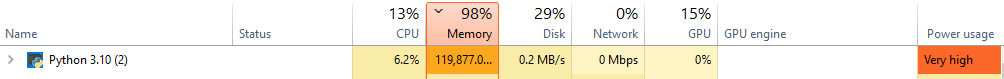

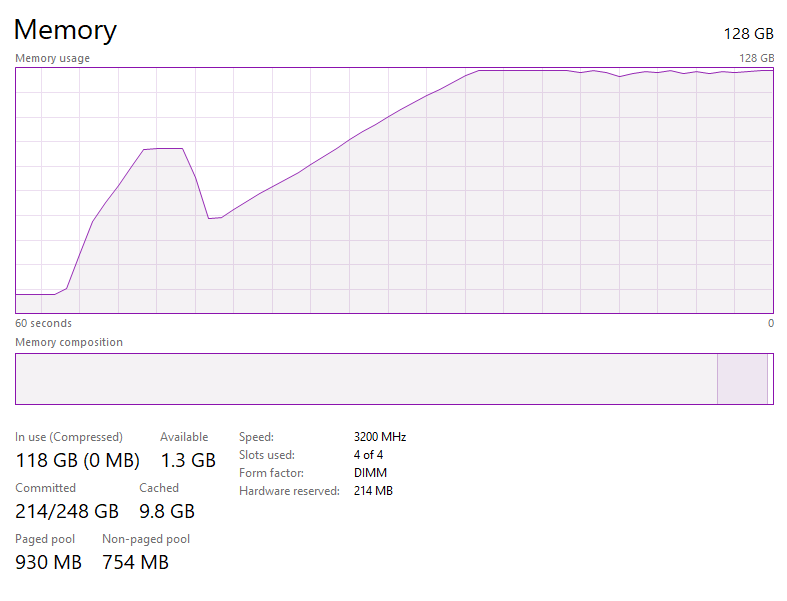

In [ ]:
permutable_A = {}
permutable_B = {}
print(permutation_spec.axes_to_perm.keys())
for key in modelA.cpu().state_dict().keys():
  if key in permutation_spec.axes_to_perm.keys():
    permutable_A[key] = modelA.cpu().state_dict()[key]
for key in modelB.cpu().state_dict().keys():
  if key in permutation_spec.axes_to_perm.keys():
    permutable_B[key] = modelB.cpu().state_dict()[key]
final_permutation = weight_matching(permutation_spec,
                                        permutable_A, permutable_B)

updated_params = apply_permutation(permutation_spec, final_permutation, flatten_params(model_b))

dict_keys(['embedding.weight', 'decoder_layer.linear1.weight', 'decoder_layer.linear2.weight', 'output_layer.weight'])


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

p1
0/p1: 30.626537322998047
p2
0/p2: 10.424471855163574
p3


In [ ]:
model_b.load_state_dict(updated_params)
model_b.cuda()
model_a.cuda()
model_a_dict = copy.deepcopy(model_a.state_dict())
model_b_dict = copy.deepcopy(model_b.state_dict())
test_loss_interp_perm = []
  for lam in tqdm(lambdas):
    naive_p = lerp(lam, model_a_dict, model_b_dict)
    modelMerged.load_state_dict(naive_p)
    test_loss = test(modelMerged.cuda())
    test_loss_interp_perm.append(test_loss.cpu())

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(lambdas,
          test_loss_interp_naive,
          linestyle="dashed",
          color="tab:blue",
          alpha=0.25,
          linewidth=2,
          label="Test, permutation interp.")
ax.set_xlabel("$\lambda$")
ax.set_xticks([0, 1])
ax.set_xticklabels(["Model $A$", "Model $B$"])
ax.set_ylabel("Loss")
ax.set_title(f"Accuracy between the two models: Permutation Averaging")
ax.legend(loc="lower right", framealpha=0.5)
fig.tight_layout()
fig.show()